### Assignment 2:

1. Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?
2. Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?
3. Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [31]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [32]:
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

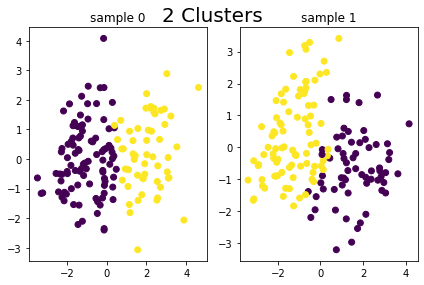

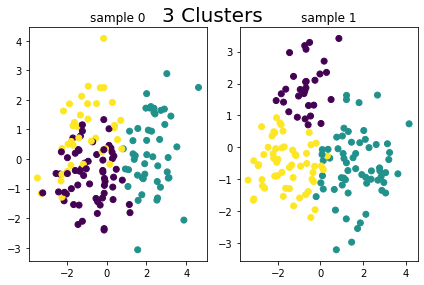

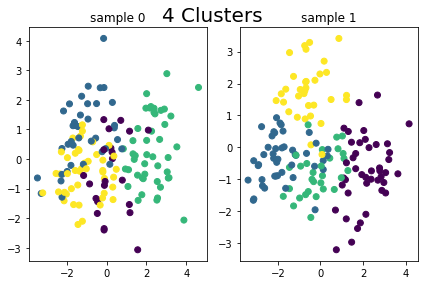

In [33]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

From above we can see that, with cluster 2 gives us better consistency.

2. ARI:

In [34]:
from sklearn.metrics.cluster import adjusted_rand_score
pred1 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred2 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred3 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for K=2 :{:0.2f} ".format(adjusted_rand_score(y, pred1)))
print("ARI for K=3 :{:0.2f} ".format(adjusted_rand_score(y, pred2)))
print("ARI for K=4 :{:0.2f} ".format(adjusted_rand_score(y, pred3)))

ARI for K=2 :0.44 
ARI for K=3 :0.28 
ARI for K=4 :0.20 


From above we can see that for k means of 2 got higher ARI which is better than other two.

In [35]:

pred1 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred2 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred3 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("silhouette_score for K=2 :{:0.2f} ".format(metrics.silhouette_score(X_std, pred1, metric='euclidean')))
print("silhouette_score for K=3 :{:0.2f} ".format(metrics.silhouette_score(X_std, pred2, metric='euclidean')))
print("silhouette_score for K=4 :{:0.2f} ".format(metrics.silhouette_score(X_std, pred3, metric='euclidean')))

silhouette_score for K=2 :0.17 
silhouette_score for K=3 :0.13 
silhouette_score for K=4 :0.13 


K means of 2 gives better silhouette score.
So K= 2 is a best model.

## Assignment 3:
- Produce dendrograms for the heart disease dataset using three different linkage methods: complete, average and ward. Which linkage method do you think produces more reasonable result?
- Apply agglomerative clustering to the heart disease data by setting n_clusters=2. Try the three linkage methods above and get ARI and silhouette scores for each of your solutions. Compare the results with each other and with that of the k-means solution that you implemented in the assignment of the previous checkpoint. Which algorithm and setting does perform better?

### Using complete linkage:

In [36]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

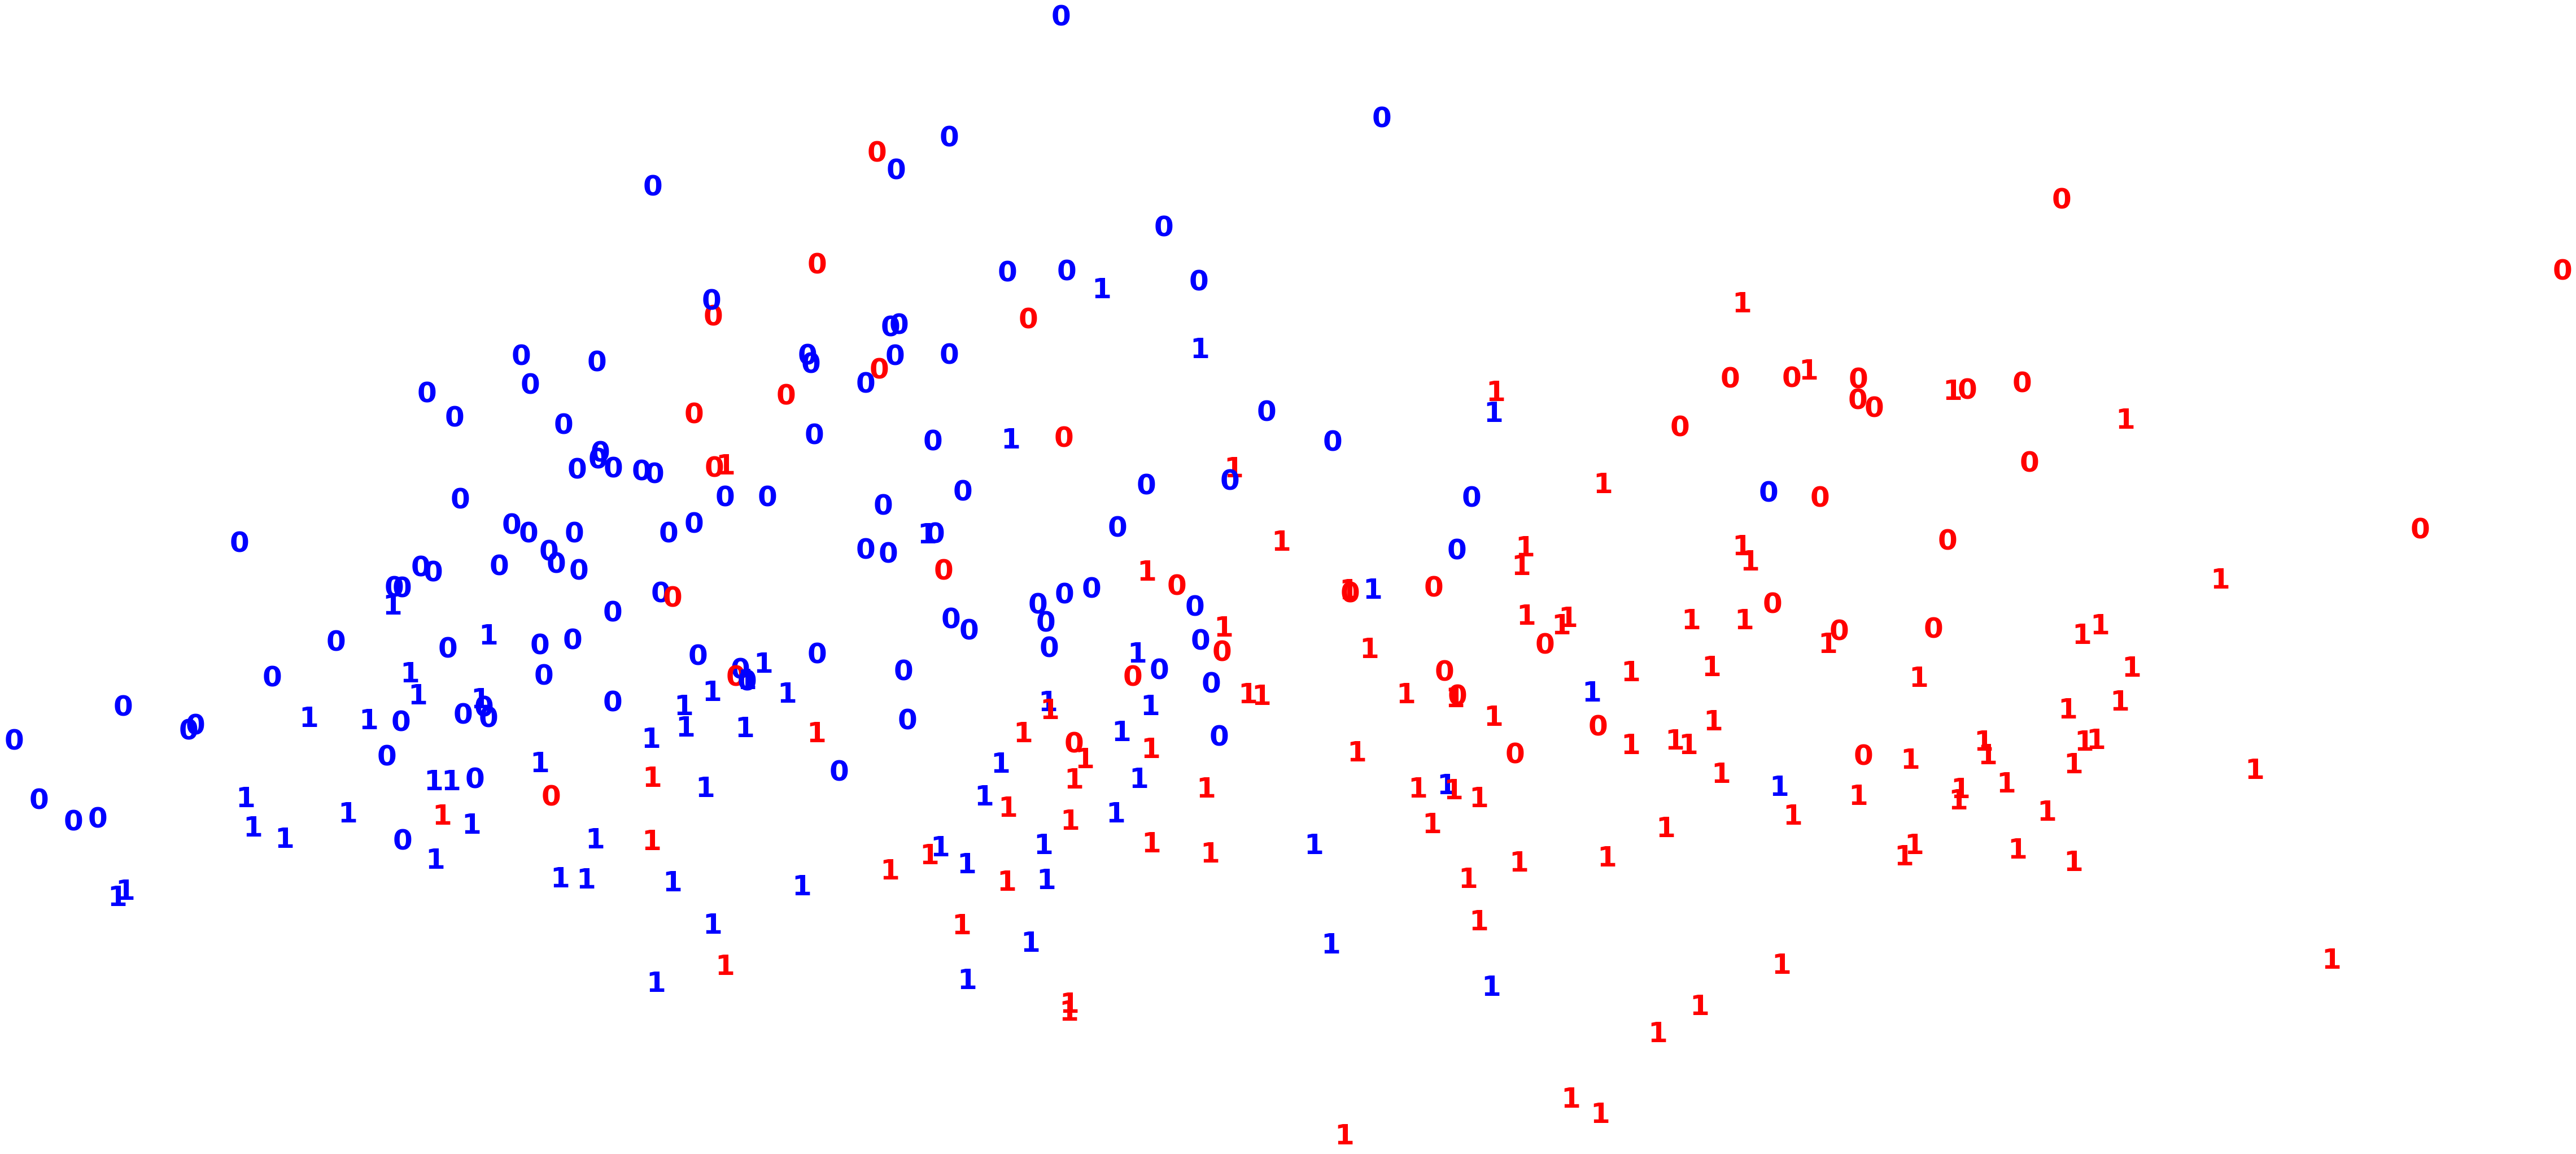

Adjusted Rand Index of the Agglomerative Clustering solution w/ complete linkage: 0.10233468474116167
The silhoutte score of the Agglomerative Clustering solution w/ complete linkage: 0.07445588349053094


In [37]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

print("Adjusted Rand Index of the Agglomerative Clustering solution w/ complete linkage: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution w/ complete linkage: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

### Using Average linkage:

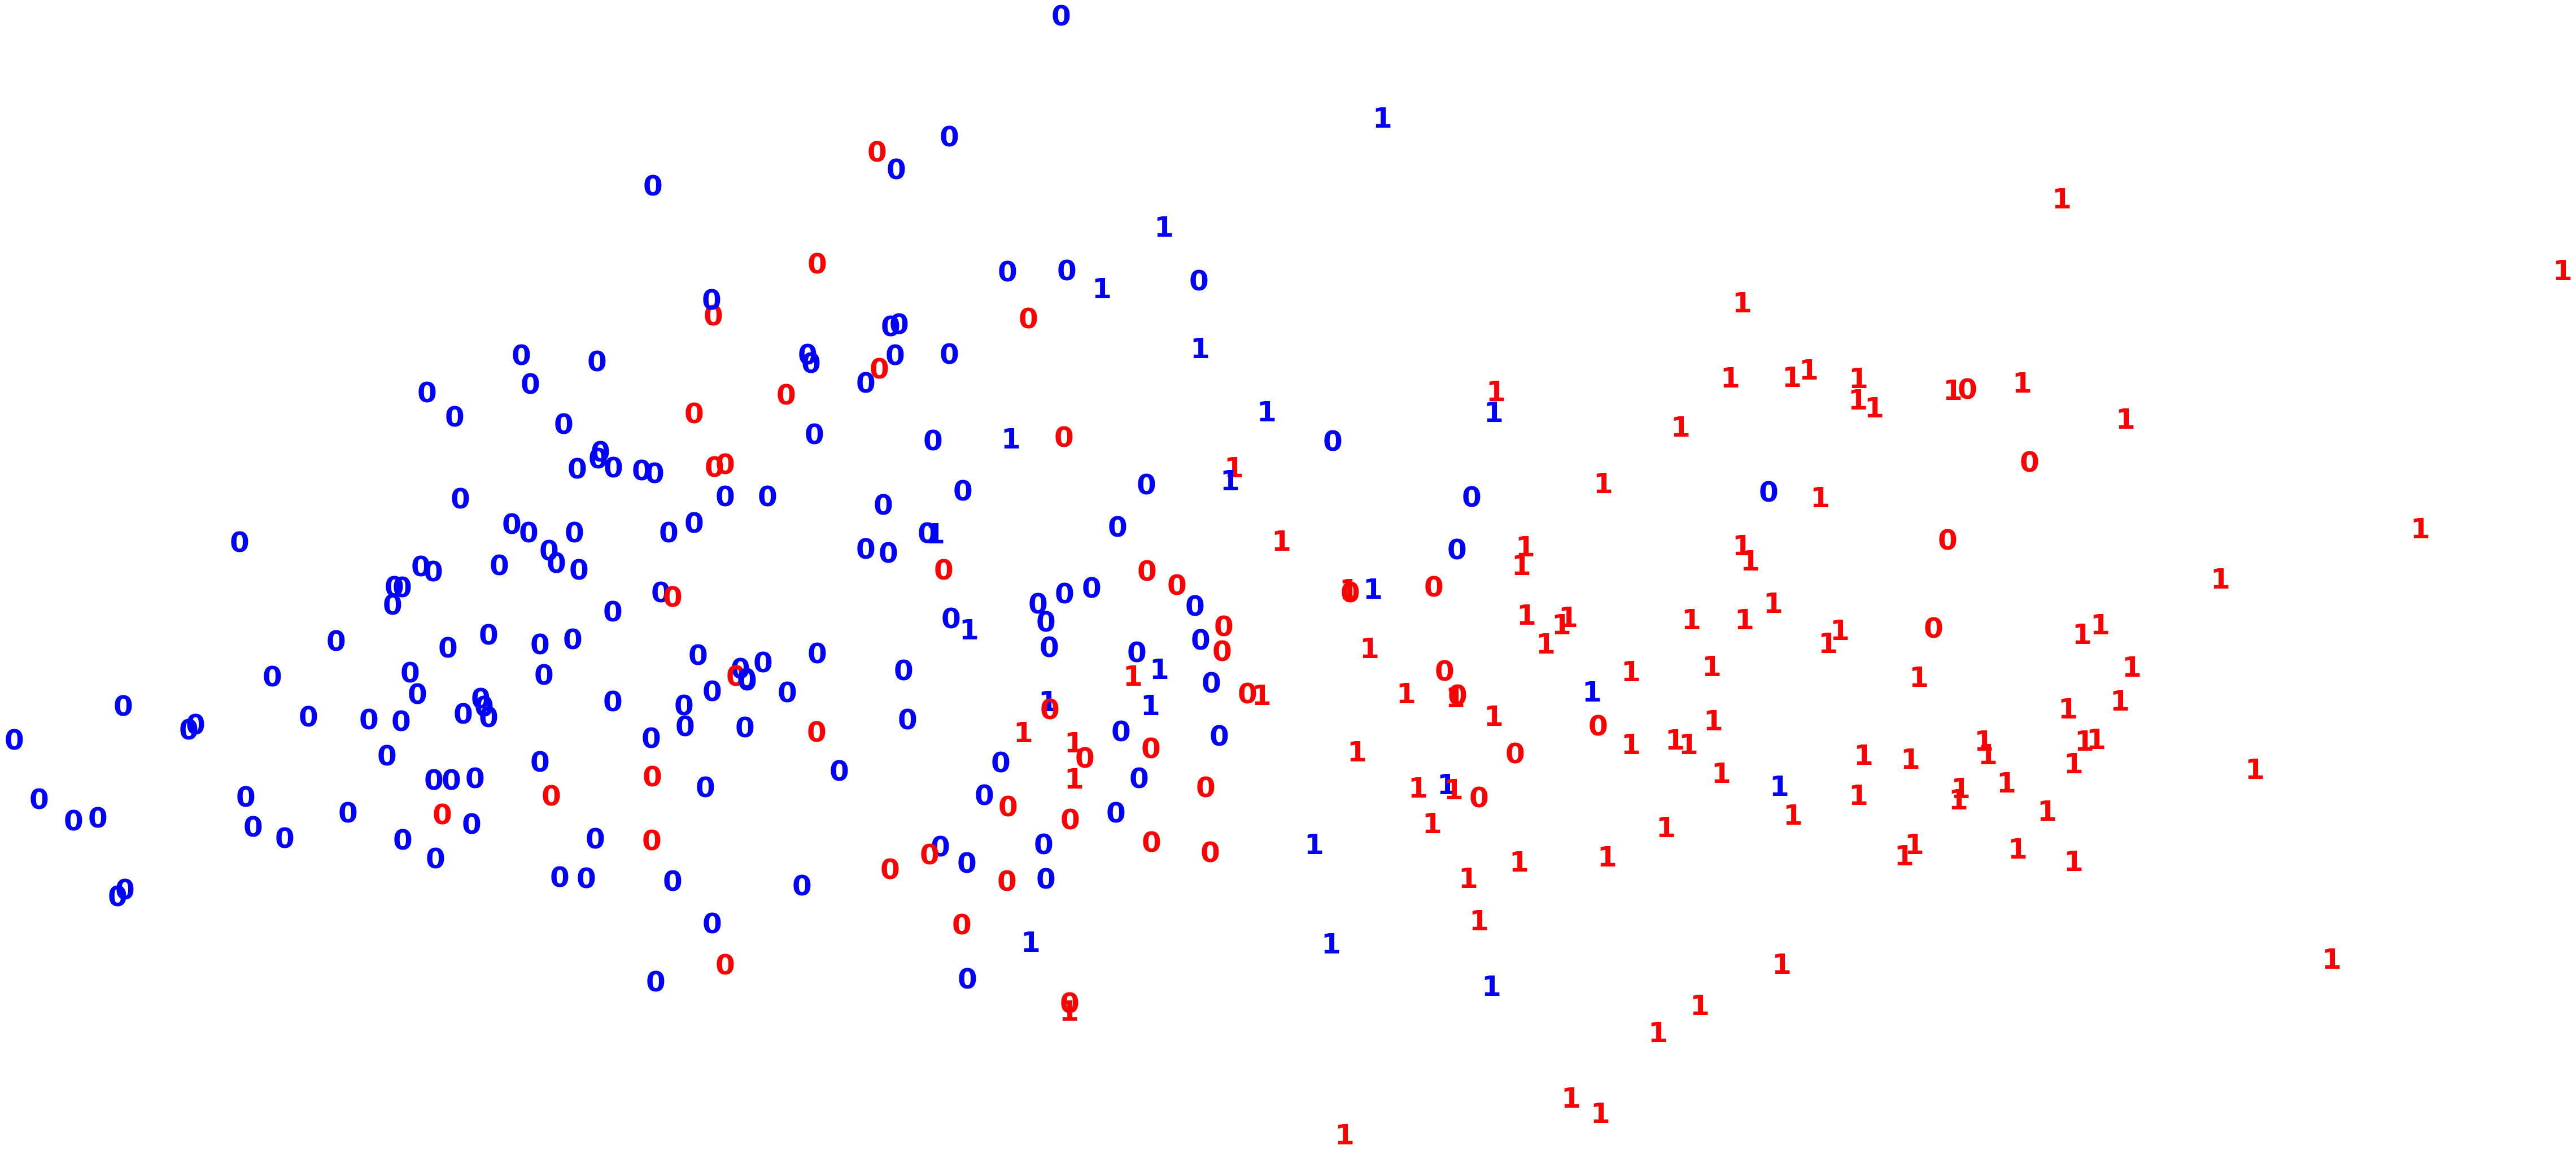

Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: 0.29242115793299467
The silhoutte score of the Agglomerative Clustering solution w/ average linkage: 0.14746387683622914


In [38]:
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution w/ average linkage: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

### Using ward linkage:

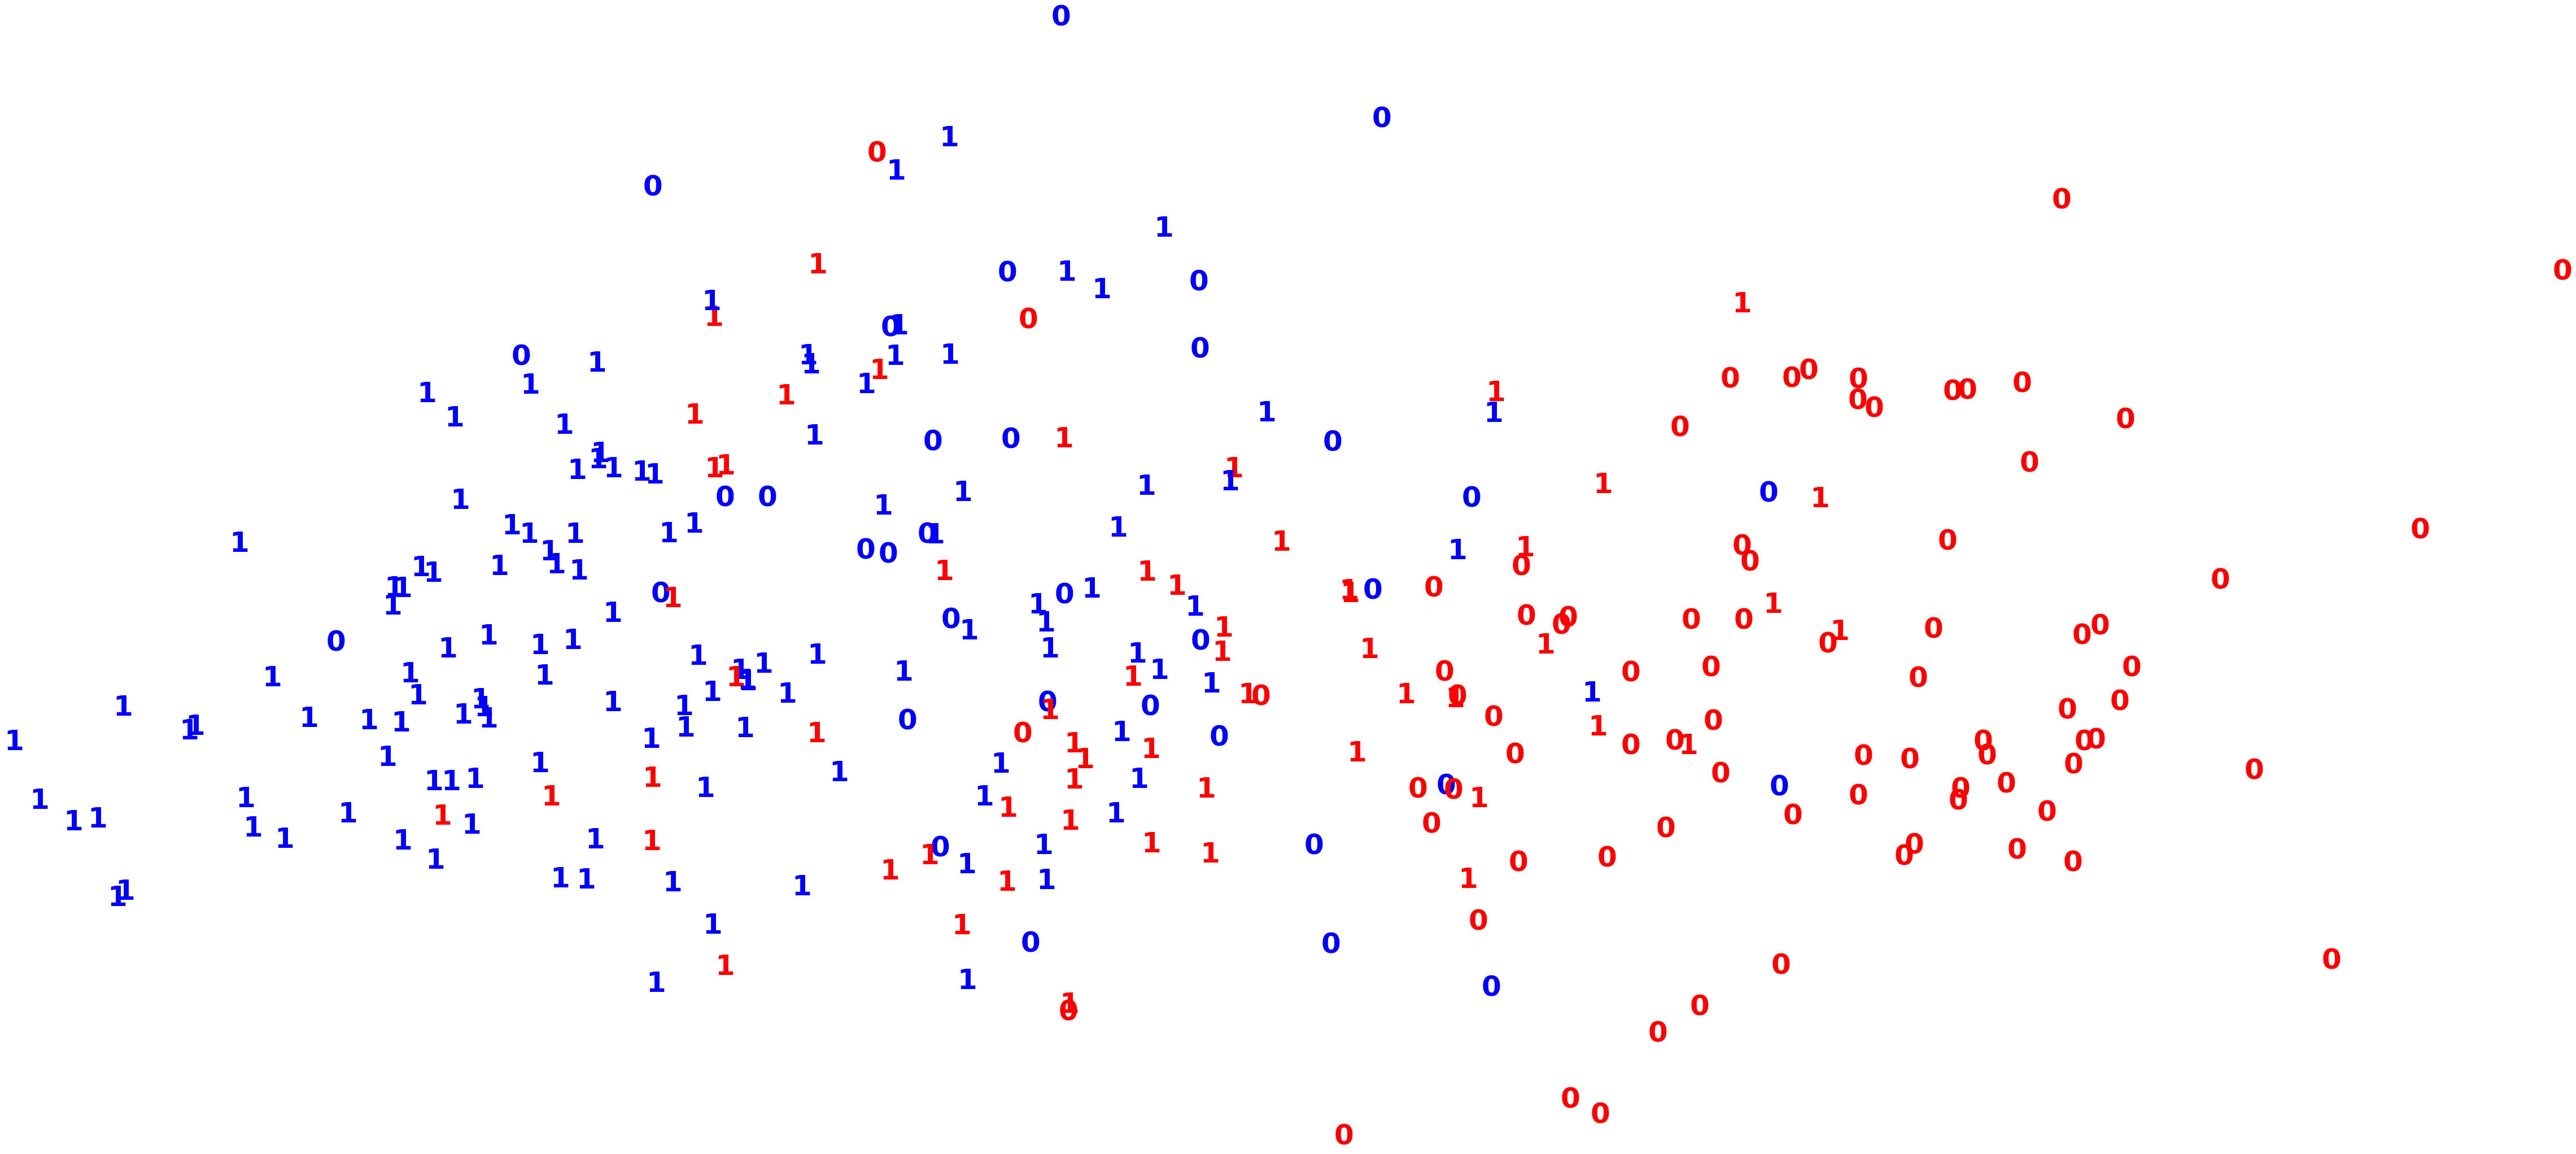

Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: 0.14457486386986915
The silhoutte score of the Agglomerative Clustering solution w/ average linkage: 0.1377396413078055


In [39]:
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution w/ average linkage: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Observation:
- ARI and Silhoutte score is higher when k-means was used than using clustering and different linkage.

### Dendograms using different linkage:

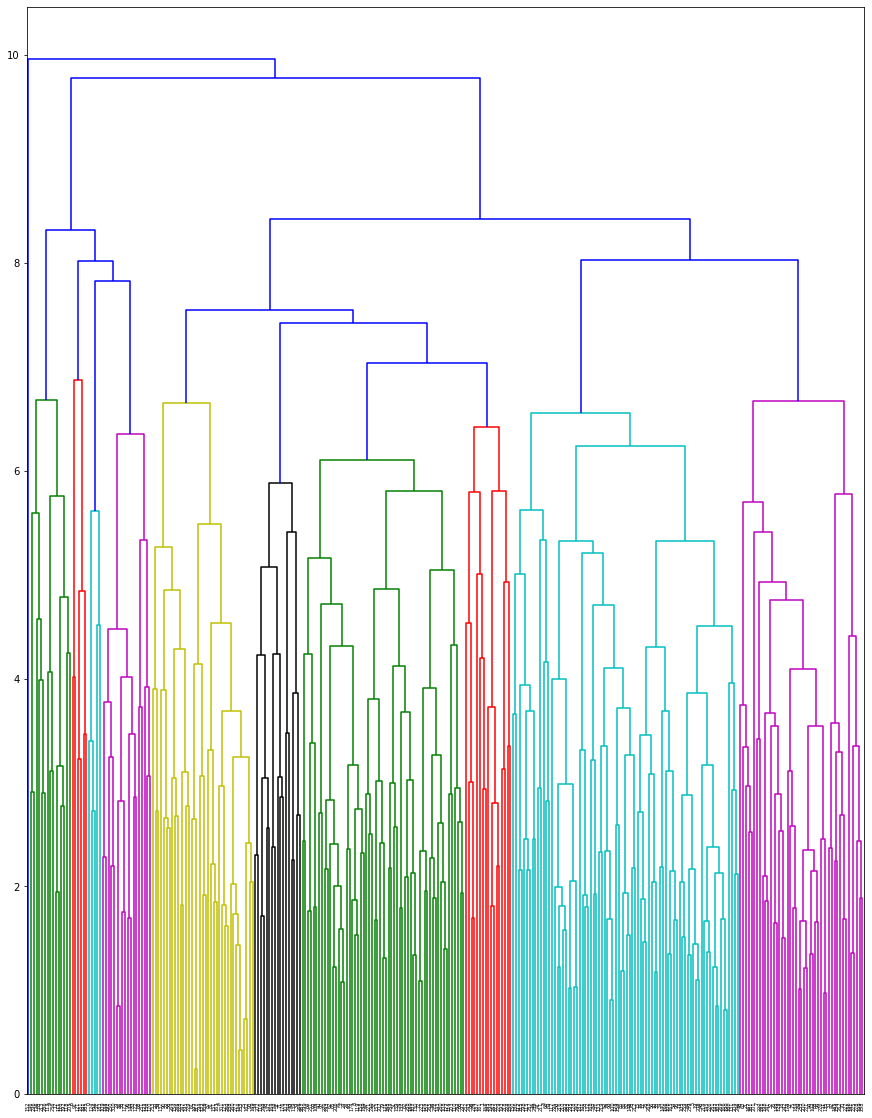

In [40]:
#complete linkage
plt.figure(figsize=(15,20))
dendrogram(linkage(X_std, method='complete'))
plt.show()

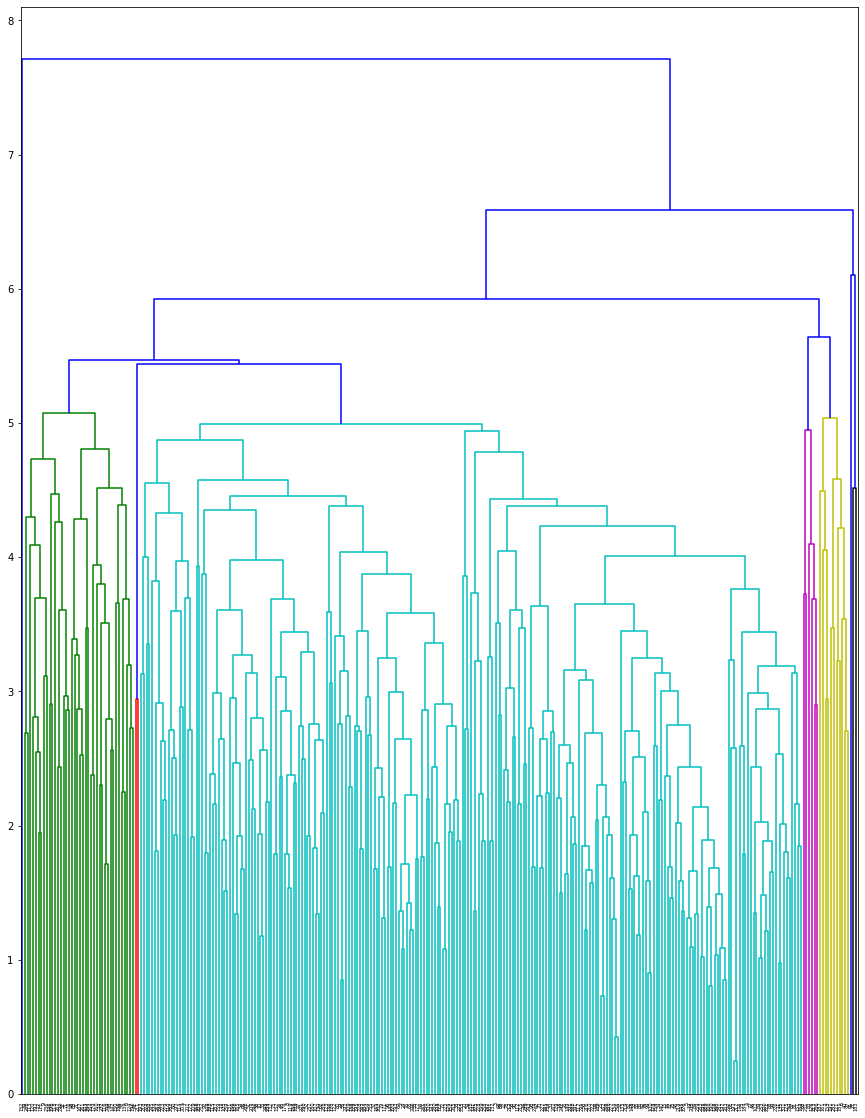

In [41]:
#average linkage
plt.figure(figsize=(15,20))
dendrogram(linkage(X_std, method='average'))
plt.show()

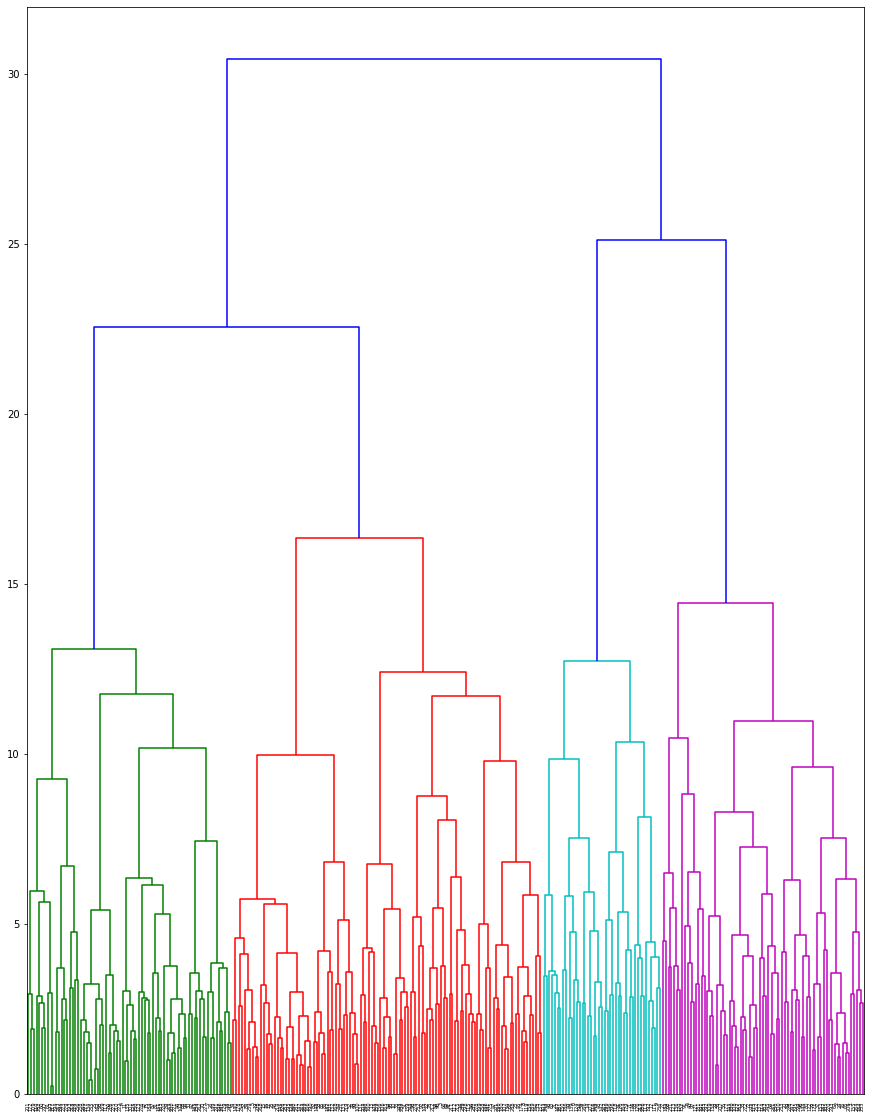

In [42]:
# ward linkage
plt.figure(figsize=(15,20))
dendrogram(linkage(X_std, method='ward'))
plt.show()

Looking dendrogram, I can see that ward linkage done better job than other two, other to is really hard to see 